# Random Forest and Extra Trees as examples of the ensemble methods

## Introduction 

Both algorithms are so called ensemble methods. These are techniques that combine the predictions from multiple machine learning models to produce a single, more accurate result. The idea is that a group of models (ensemble) working together will outperform any individual model.

Both Random Forests and Extra Trees are ensemble methods that use multiple **decision trees** as their base models. In other words, decision trees are the building blocks of these algorithms.

How do they work?
- Instead of building one decision tree, these algorithms build a **forest** of trees and aggregate the results.
- Making Predictions:
  - **Classification Tasks:** Each tree in the ensemble predicts a class label. The final prediction is made by **majority voting**—the class that gets the most votes from all the trees is chosen.
  - **Regression Tasks:** Each tree predicts a numerical value. The final prediction is the **average** of all the tree predictions.
- Finally, the predictions from all the trees are **aggregated** to make a final prediction. This process helps to reduce overfitting and improves generalization to unseen data.

For better understanding of the algorithms, I would recommend watching the following videos from Normalized Nerd YT channel:
- [Decision Trees](https://youtu.be/ZVR2Way4nwQ)
- [Classification Random Forest](https://youtu.be/v6VJ2RO66Ag)
- [Regression Random Forest](https://youtu.be/UhY5vPfQIrA)

Here are some key screenshots from the videos:


![Decision Tree Classification](../images/decision-tree-classification.png)

![Decision Tree Split Selection](../images/decision-tree-classification-split-selection.png)

![Decision Tree Split Selection](../images/decision-tree-regression-split-selection.png)

![Decision Tree Regression](../images/decision-tree-regression-aggregation.png)

![Random Forest Classification](../images/random-forest-classification.png)

Here are some key differences between Random Forest and Extra Trees:

## Random Forests:

**Data Sampling:** Random Forests use a technique called *bootstrap aggregation* or *bagging*. This means that each tree in the forest is trained on a random subset of the original data, created by sampling with replacement. So, some data points might appear multiple times in a subset, and some might not appear at all.

**Feature Selection and Splitting:**
- At each node (decision point) in a tree, a random subset of features is selected.
- The algorithm then looks for the best possible split among these features by evaluating all possible thresholds (e.g., for "age," it might consider "age > 30," "age > 35," etc.).
- The split that best separates the data based on a criterion (like Gini impurity or information gain) is chosen.

## Extremely Randomized Trees (Extra Trees):

**Data Sampling:** Extra Trees use the *entire* original dataset to train each tree, without any bootstrapping. So, every tree sees all the data points.

**Feature Selection and Splitting:**
- At each node, a random subset of features is still selected, just like in Random Forests.
- **However, the key difference is in how splits are decided:**
  - For each of these randomly chosen features, a split point (threshold) is selected **randomly**, not based on the best possible split.
  - Among these randomly generated splits, the one that provides the best separation (according to the same criteria used in Random Forests) is chosen.


In [200]:
# imports
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from sklearn import tree
from imblearn.over_sampling import SMOTE

## Hands-on example using the Wine Quality dataset

In this notebook, I will show you how to use Random Forest and Extra Trees for classification tasks using the `scikit-learn` library. We will use the [Wine Quality dataset](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset) for this purpose.

In [169]:
# Download the latest version of the dataset
path = kagglehub.dataset_download("yasserh/wine-quality-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/vmorskyi/.cache/kagglehub/datasets/yasserh/wine-quality-dataset/versions/1


### Information about the dataset from Kaggle:

**Description:**

This datasets is related to red variants of the Portuguese "Vinho Verde" wine.The dataset describes the amount of various chemicals present in wine and their effect on it's quality. The datasets can be viewed as classification or regression tasks. The classes are ordered and **not balanced (e.g. there are much more normal wines than excellent or poor ones)**.

A simple yet challenging project, to anticipate the quality of wine.
The complexity arises due to the fact that the dataset has fewer samples, & is highly imbalanced.

**This data frame contains the following columns:**

Input variables (based on physicochemical tests):\
1 - fixed acidity\
2 - volatile acidity\
3 - citric acid\
4 - residual sugar\
5 - chlorides\
6 - free sulfur dioxide\
7 - total sulfur dioxide\
8 - density\
9 - pH\
10 - sulphates\
11 - alcohol

Output variable (based on sensory data):\
12 - quality (score between 0 and 10)



### EDA and Data Preprocessing

Let's start by loading the data and performing some exploratory data analysis (EDA) and data preprocessing steps.

In [170]:
!ls -l $path

total 160
-rw-r--r--@ 1 vmorskyi  staff  78057 Dec  4 10:36 WineQT.csv


In [171]:
# Load the dataset and display the first few rows
wine_data_path = path + "/WineQT.csv"
wine_df = pd.read_csv(wine_data_path)
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [172]:
# Display basic information
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


In [173]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


quality
3      6
4     33
5    483
6    462
7    143
8     16
Name: count, dtype: int64

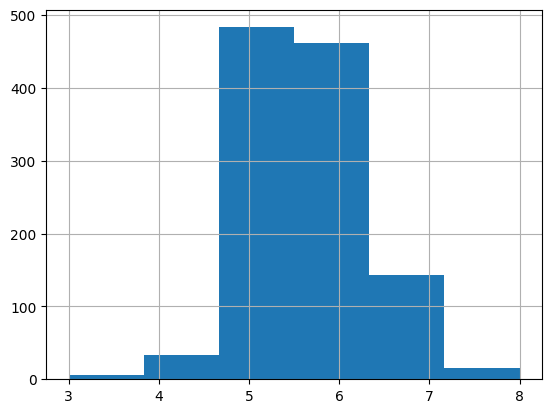

In [174]:
# Check the distribution of the 'quality' variable
wine_df.quality.hist(bins=6)
wine_df.quality.value_counts().sort_index()

In [175]:
# Separate features and target variable
X = wine_df.drop(['quality', 'Id'], axis=1)
y = wine_df['quality']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [176]:
# Training and test set sizes
pd.concat([y_train.value_counts(), y_test.value_counts()], axis=1, keys=['Train', 'Test']).sort_index()

,Train,Test
quality,,
3,5,1
4,26,7
5,386,97
6,370,92
7,114,29
8,13,3


### Initialize, fit and predict using Random Forest and Extra Trees

Next, we will initialize, fit, and predict using Random Forest and Extra Trees classifiers. We will compare the performance of both algorithms.

In [177]:
# Initialize, fit and predict using the classifiers
rf_classifier = RandomForestClassifier(random_state=42)
et_classifier = ExtraTreesClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)
et_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)
y_pred_et = et_classifier.predict(X_test)

In [178]:
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.74      0.85      0.79        97
           6       0.69      0.74      0.71        92
           7       0.74      0.48      0.58        29
           8       0.00      0.00      0.00         3

    accuracy                           0.72       229
   macro avg       0.36      0.34      0.35       229
weighted avg       0.68      0.72      0.69       229



/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklea

Text(0.5, 1.0, 'Random Forest Confusion Matrix')

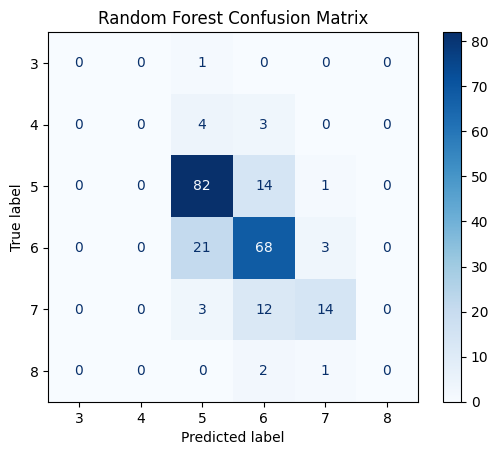

In [179]:
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_classifier.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_classifier.classes_)
disp_rf.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")

In [180]:
print("Extra Trees Classification Report:")
print(classification_report(y_test, y_pred_et))

Extra Trees Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.73      0.84      0.78        97
           6       0.68      0.75      0.72        92
           7       0.82      0.48      0.61        29
           8       0.00      0.00      0.00         3

    accuracy                           0.72       229
   macro avg       0.37      0.34      0.35       229
weighted avg       0.69      0.72      0.69       229



/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklea

Text(0.5, 1.0, 'Extra Trees Confusion Matrix')

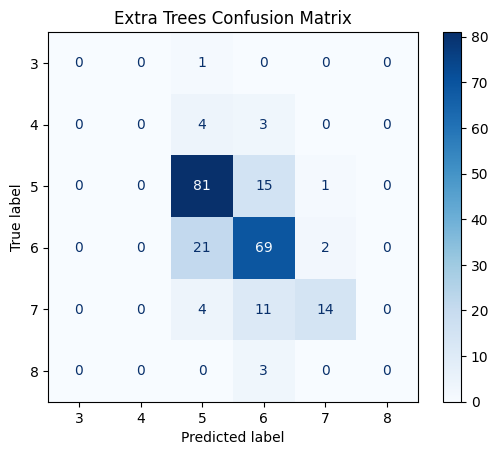

In [181]:
cm_et = confusion_matrix(y_test, y_pred_et, labels=et_classifier.classes_)
disp_et = ConfusionMatrixDisplay(confusion_matrix=cm_et, display_labels=et_classifier.classes_)
disp_et.plot(cmap='Blues')
plt.title("Extra Trees Confusion Matrix")

<Axes: title={'center': 'Random Forest Feature Importances'}, ylabel='None'>

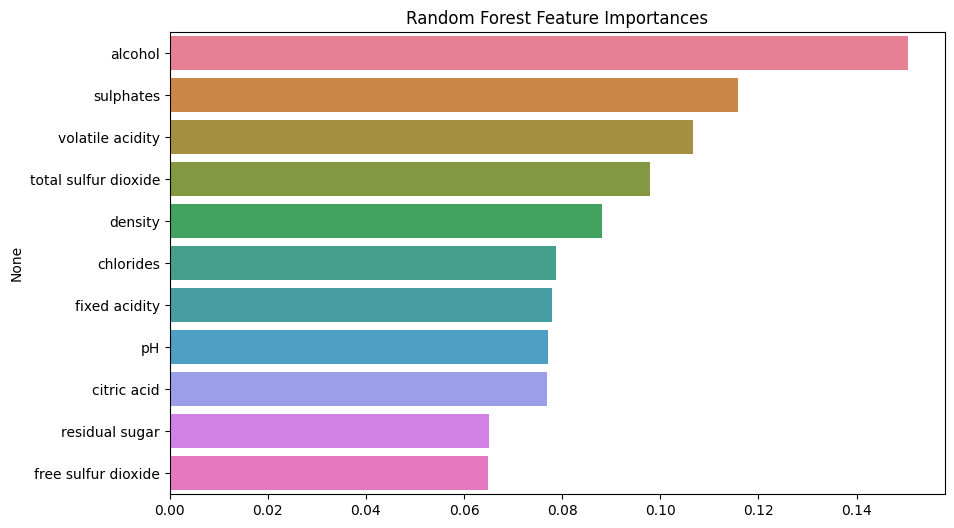

In [182]:
importances_rf = rf_classifier.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
sns.barplot(x=importances_rf[indices_rf], y=features[indices_rf], hue=features[indices_rf], legend=False)

In [183]:
classes = sorted(y.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]
y_score_rf = rf_classifier.predict_proba(X_test)
y_score_et = et_classifier.predict_proba(X_test)

In [184]:
# Initialize dictionaries to store ROC curves and AUC scores
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

fpr_et = dict()
tpr_et = dict()
roc_auc_et = dict()

for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_binarized[:, i], y_score_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    
    fpr_et[i], tpr_et[i], _ = roc_curve(y_test_binarized[:, i], y_score_et[:, i])
    roc_auc_et[i] = auc(fpr_et[i], tpr_et[i])


Text(0, 0.5, 'True Positive Rate')

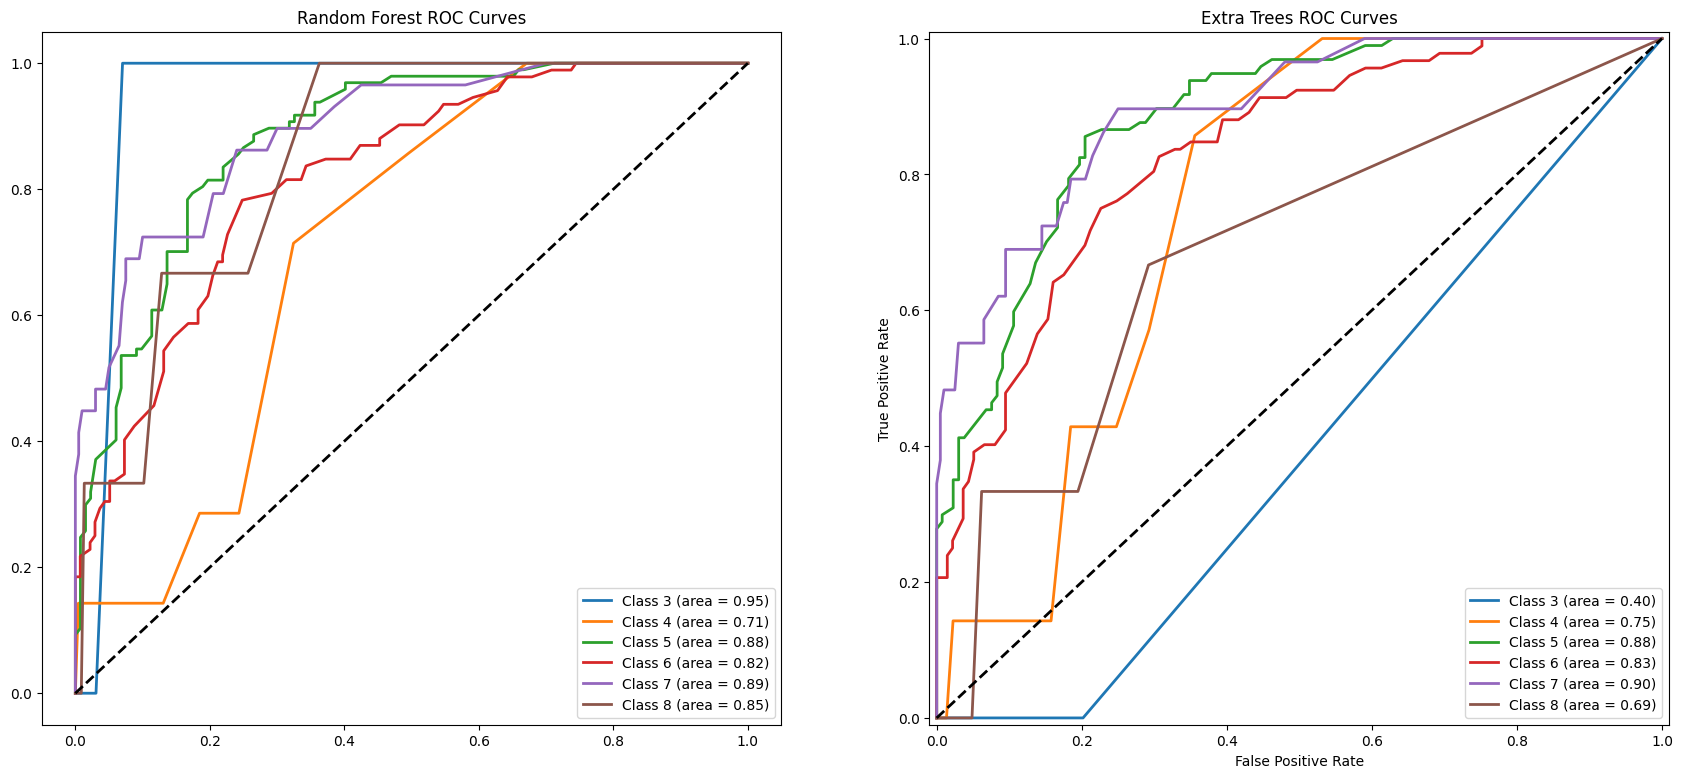

In [185]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))

for i in range(n_classes):
    ax1.plot(fpr_rf[i], tpr_rf[i], lw=2,
             label='Class {0} (area = {1:0.2f})'.format(classes[i], roc_auc_rf[i]))
    ax2.plot(fpr_et[i], tpr_et[i], lw=2,
             label='Class {0} (area = {1:0.2f})'.format(classes[i], roc_auc_et[i]))

ax1.set_title('Random Forest ROC Curves')
ax2.set_title('Extra Trees ROC Curves')

ax1.plot([0, 1], [0, 1], 'k--', lw=2)
ax2.plot([0, 1], [0, 1], 'k--', lw=2)
ax1.legend(loc='lower right')
ax2.legend(loc='lower right')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


Text(0.5, 1.0, 'Decision Tree from Random Forest')

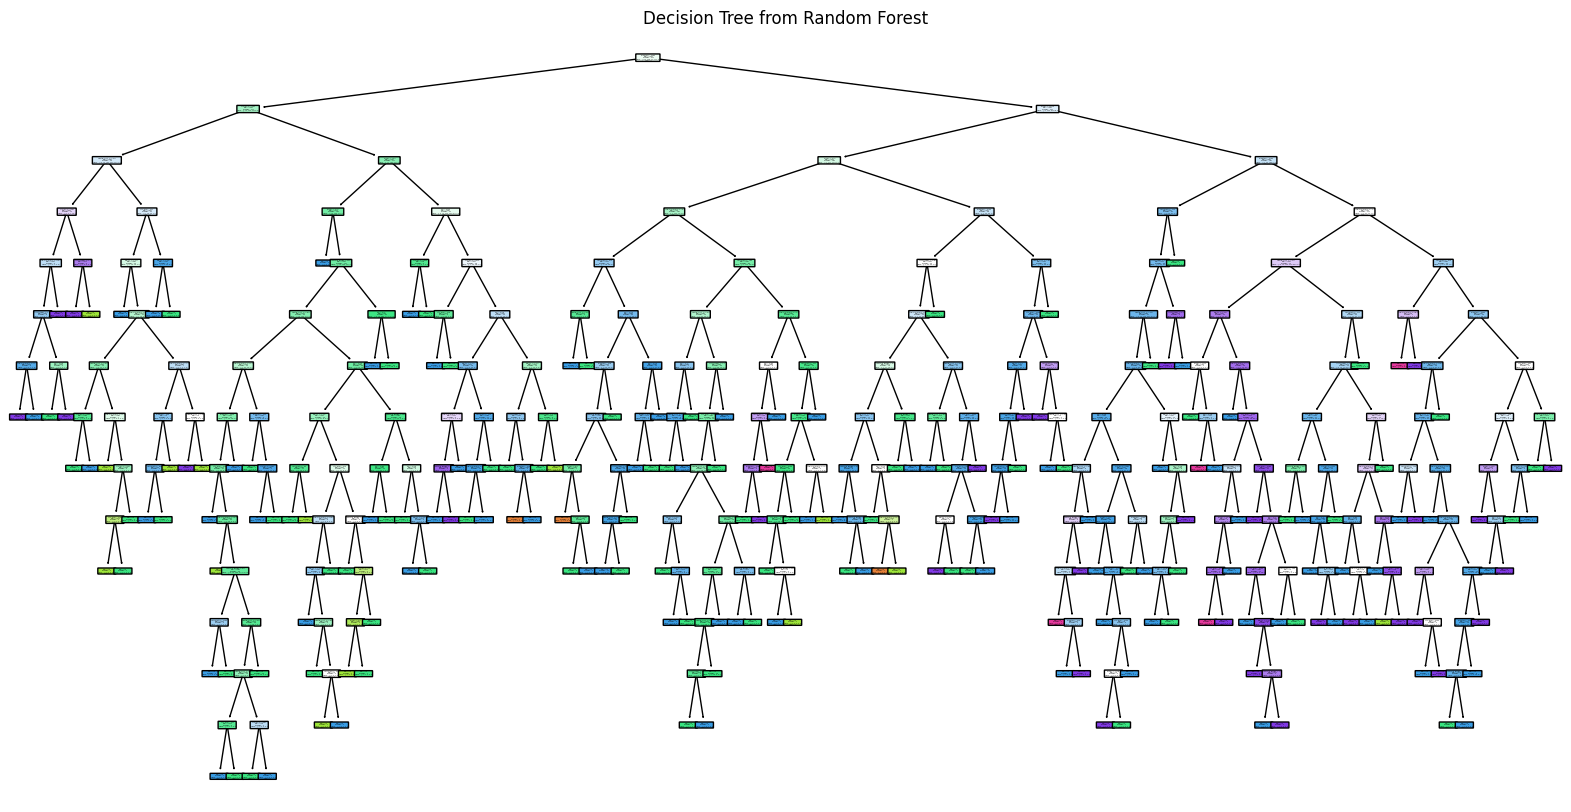

In [186]:
# Extract a single tree
estimator_rf = rf_classifier.estimators_[0]

plt.figure(figsize=(20, 10))
tree.plot_tree(estimator_rf,
               feature_names=features,
               class_names=[str(c) for c in classes],
               filled=True,
               rounded=True)
plt.title("Decision Tree from Random Forest")

## Try some balancing techniques to improve the model performance

Since the dataset is imbalanced and the results of the raw models aren't impressive, we will try some balancing techniques to improve the model performance. First, we will use the `SMOTE` technique to oversample the minority classes. Then, we will try changing the class weights in the models.

In [187]:
Counter(y_train)

Counter({5: 386, 6: 370, 7: 114, 4: 26, 8: 13, 3: 5})

In [188]:
# Desired number of samples per class
sampling_strategy = {
    3: 30,  
    4: 60,  
    5: Counter(y_train)[5],  
    6: Counter(y_train)[6],  
    7: 200, 
    8: 30
}

# Initialize and apply SMOTE to training data
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=4)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Resampled training set class distribution
Counter(y_resampled)

Counter({5: 386, 6: 370, 7: 200, 4: 60, 8: 30, 3: 30})

In [189]:
# Initialize, fit and predict using new classifiers
rf_classifier_smote = RandomForestClassifier(random_state=42)
et_classifier_smote = ExtraTreesClassifier(random_state=42)

rf_classifier_smote.fit(X_resampled, y_resampled)
et_classifier_smote.fit(X_resampled, y_resampled)

y_pred_rf_smote = rf_classifier_smote.predict(X_test)
y_pred_et_smote = et_classifier_smote.predict(X_test)

In [190]:
print("Random Forest Classification Report (After SMOTE):")
print(classification_report(y_test, y_pred_rf_smote))

Random Forest Classification Report (After SMOTE):
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.73      0.86      0.79        97
           6       0.70      0.66      0.68        92
           7       0.57      0.55      0.56        29
           8       0.00      0.00      0.00         3

    accuracy                           0.70       229
   macro avg       0.33      0.35      0.34       229
weighted avg       0.67      0.70      0.68       229



/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklea

Text(0.5, 1.0, 'Random Forest Confusion Matrix (After SMOTE)')

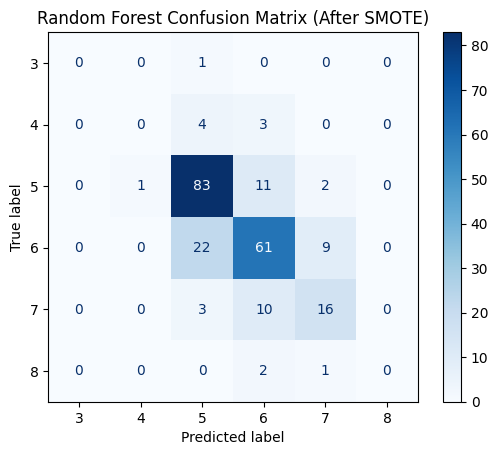

In [191]:
cm_rf_smote = confusion_matrix(y_test, y_pred_rf_smote, labels=rf_classifier_smote.classes_)
disp_rf_smote = ConfusionMatrixDisplay(confusion_matrix=cm_rf_smote, display_labels=rf_classifier_smote.classes_)
disp_rf_smote.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix (After SMOTE)")


In [192]:
print("Extra Trees Classification Report (After SMOTE):")
print(classification_report(y_test, y_pred_et_smote))

Extra Trees Classification Report (After SMOTE):
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.72      0.82      0.77        97
           6       0.65      0.67      0.66        92
           7       0.68      0.52      0.59        29
           8       0.00      0.00      0.00         3

    accuracy                           0.69       229
   macro avg       0.34      0.34      0.34       229
weighted avg       0.65      0.69      0.67       229



/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklea

Text(0.5, 1.0, 'Random Forest Confusion Matrix (After SMOTE)')

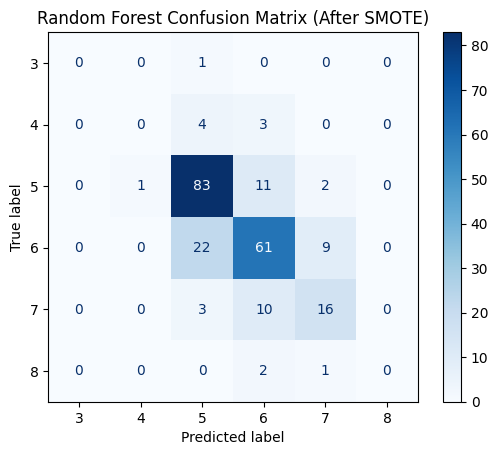

In [193]:
cm_rf_smote = confusion_matrix(y_test, y_pred_rf_smote, labels=rf_classifier_smote.classes_)
disp_rf_smote = ConfusionMatrixDisplay(confusion_matrix=cm_rf_smote, display_labels=rf_classifier_smote.classes_)
disp_rf_smote.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix (After SMOTE)")

In [194]:
# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))

class_weight_dict

{np.int64(3): np.float64(30.466666666666665),
 np.int64(4): np.float64(5.858974358974359),
 np.int64(5): np.float64(0.3946459412780656),
 np.int64(6): np.float64(0.4117117117117117),
 np.int64(7): np.float64(1.3362573099415205),
 np.int64(8): np.float64(11.717948717948717)}

In [195]:
# Initialize, fit and predict using classifiers with class weights
rf_classifier_weighted = RandomForestClassifier(
    class_weight=class_weight_dict,
    random_state=42
)
et_classifier_weighted = ExtraTreesClassifier(
    class_weight=class_weight_dict,
    random_state=42
)

rf_classifier_weighted.fit(X_train, y_train)
et_classifier_weighted.fit(X_train, y_train)

y_pred_rf_weighted = rf_classifier_weighted.predict(X_test)
y_pred_et_weighted = et_classifier_weighted.predict(X_test)


In [196]:
print("Random Forest Classification Report (With Class Weights):")
print(classification_report(y_test, y_pred_rf_weighted))

Random Forest Classification Report (With Class Weights):
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.70      0.80      0.75        97
           6       0.63      0.66      0.65        92
           7       0.70      0.48      0.57        29
           8       0.00      0.00      0.00         3

    accuracy                           0.67       229
   macro avg       0.34      0.32      0.33       229
weighted avg       0.64      0.67      0.65       229



/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklea

Text(0.5, 1.0, 'Random Forest Confusion Matrix (With Class Weights)')

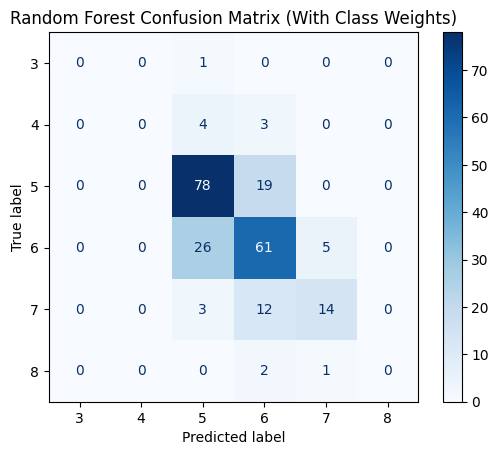

In [197]:
cm_rf_weighted = confusion_matrix(y_test, y_pred_rf_weighted, labels=rf_classifier_weighted.classes_)
disp_rf_weighted = ConfusionMatrixDisplay(confusion_matrix=cm_rf_weighted, display_labels=rf_classifier_weighted.classes_)
disp_rf_weighted.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix (With Class Weights)")


In [198]:
print("Extra Trees Classification Report (With Class Weights):")
print(classification_report(y_test, y_pred_et_weighted))

Extra Trees Classification Report (With Class Weights):
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.72      0.81      0.76        97
           6       0.64      0.72      0.68        92
           7       0.81      0.45      0.58        29
           8       0.00      0.00      0.00         3

    accuracy                           0.69       229
   macro avg       0.36      0.33      0.34       229
weighted avg       0.66      0.69      0.67       229



/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vmorskyi/Library/CloudStorage/OneDrive-Personal/University/Lectures/DD - Drzewa decyzyjne/Random Forests/.venv/lib/python3.13/site-packages/sklea

Text(0.5, 1.0, 'Extra Trees Confusion Matrix (With Class Weights)')

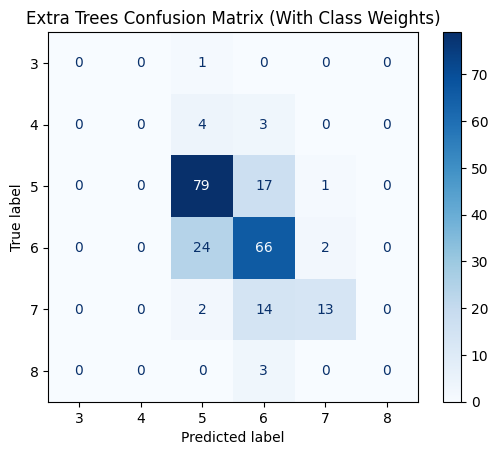

In [ ]:
cm_et_weighted = confusion_matrix(y_test, y_pred_et_weighted, labels=et_classifier_weighted.classes_)
disp_et_weighted = ConfusionMatrixDisplay(confusion_matrix=cm_et_weighted, display_labels=et_classifier_weighted.classes_)
disp_et_weighted.plot(cmap='Blues')
plt.title("Extra Trees Confusion Matrix (With Class Weights)")